In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.spatial as scspatial
import scipy.special as scspecial
from desmin_reconstruction.plotting import line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from jaxtyping import ArrayLike, Float
from tqdm import tqdm


COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}
LABEL_DICT = {"desmin": "Desmin", "actin": "Actin", "actinin": "α-actinin"}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
out = df.partition_by("probe")

In [88]:
def n_sphere_surface_area(n: int, r: float | ArrayLike = 1.0) -> float | ArrayLike:
    """Calculates the surface area of an n-sphere with radius r.

    Reference: https://en.wikipedia.org/wiki/N-sphere#Volume_and_area"""
    coeff = 2 * np.pi ** (n / 2) / scspecial.gamma(n / 2)
    return coeff * r ** (n - 1)


def n_sphere_volume(n: int, r: float | ArrayLike = 1.0) -> float | ArrayLike:
    """Calculates the volume of an n-sphere with radius r.

    Reference: https://en.wikipedia.org/wiki/N-sphere#Volume_and_area"""
    coeff = np.pi ** (n / 2) / scspecial.gamma(n / 2 + 1)
    return coeff * r**n


def bin_centers_and_widths(
    bin_edges: Float[np.ndarray, " bins"],
) -> tuple[Float[np.ndarray, " bins-1"], Float[np.ndarray, " bins-1"]]:
    bins_left, bins_right = bin_edges[:-1], bin_edges[1:]
    widths = bins_right - bins_left
    centers = (bins_left + bins_right) / 2
    return centers, widths


def point_to_set_correlation(
    coord_point: Float[np.ndarray, "num_points dim"],
    coord_set: Float[np.ndarray, "num_set dim"],
    roi: BoundingSquare,
    distance_bins: Float[np.ndarray, " bins"],
) -> Float[np.ndarray, " bins-1"]:
    n_points, dim = coord_point.shape

    tree_set = scspatial.KDTree(coord_set)
    point_to_set_dists = tree_set.query(coord_point)
    H_ab: Float[np.ndarray, " bins-1"] = np.histogram(
        point_to_set_dists, distance_bins
    )[0]

    rng = np.random.default_rng()
    coords_uniform = rng.uniform(
        [roi.x0, roi.y0, 0.5], [roi.x0 + 4, roi.y0 + 4, 1.5], size=(10000, 3)
    )
    tree_uniform = scspatial.KDTree(coords_uniform)

    cumulative_counts = []
    for dist in tqdm(distance_bins):
        in_range_points = np.unique(
            np.concatenate(tree_set.query_ball_tree(tree_uniform, dist))
        )
        cumulative_counts.append(len(in_range_points))
    cumulative_counts = np.asarray(cumulative_counts)

    coeff = 10000 / (np.diff(cumulative_counts) * n_points)

    return coeff * H_ab

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3, 100) and arg 1 with shape (3,).

In [24]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 150/150 [05:58<00:00,  2.39s/it]


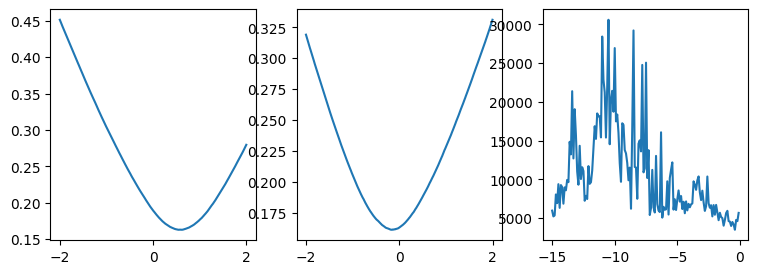

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_final = {k: transform_fn(v) for k, v in points.items()}

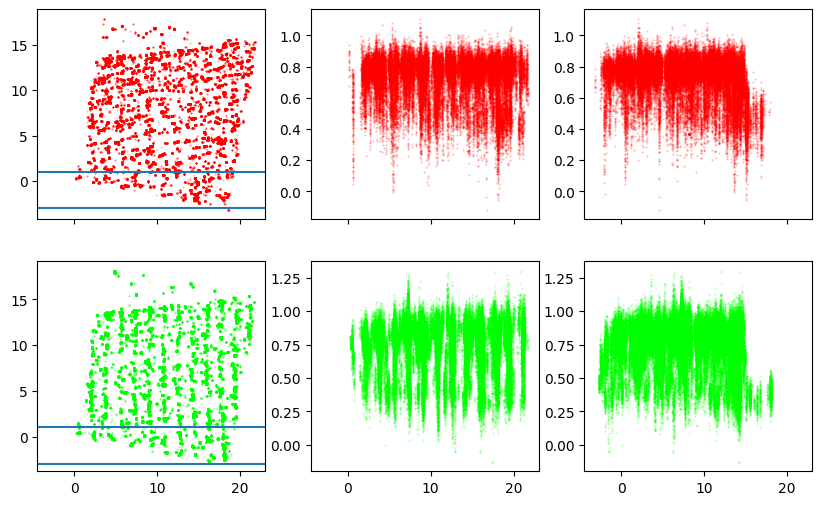

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    ax.axhline(y=1)
    ax.axhline(y=-3)

In [6]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [47]:
idx = 9
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

In [61]:
tree = scspatial.KDTree(sq1["actinin"])
distances, _ = tree.query(sq1["desmin"])
distances.shape

(2464,)

In [74]:
rng = np.random.default_rng()
out = rng.uniform(
    [bbox.x0, bbox.y0, 0], [bbox.x0 + 4, bbox.y0 + 4, 1.25], size=(10000, 3)
)
tree_uniform = scspatial.KDTree(out)

In [75]:
distance_bins = np.linspace(0, 1.0, 100)
normalize_counts = []
for r in tqdm(distance_bins):
    in_range_points = np.unique(np.concatenate(tree.query_ball_tree(tree_uniform, r)))
    normalize_counts.append(len(in_range_points))

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


In [76]:
normalize_counts = np.asarray(normalize_counts)

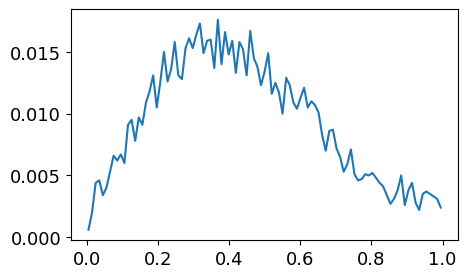

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(
    0.5 * (distance_bins[:-1] + distance_bins[1:]),
    (normalize_counts[1:] - normalize_counts[:-1]) / 10000,
)

In [50]:
result = tree.query_ball_point(out, 0.5)

In [53]:
np.unique(np.concatenate(result))

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.884e+03, 5.885e+03,
       5.886e+03], shape=(5010,))

(array([1.50118113, 2.04160634, 1.44113389, 0.6605197 , 0.42033072,
        0.36028347, 0.24018898, 0.48037796, 1.02080317, 1.74137011,
        2.04160634, 2.34184257, 3.00236226, 3.42269298, 3.54278747,
        3.12245675, 3.60283472, 3.66288196, 2.46193706, 2.82222053,
        2.16170083, 1.08085042, 0.72056694, 0.42033072, 0.36028347,
        0.30023623, 0.42033072, 0.48037796, 0.54042521, 0.96075592,
        0.54042521, 0.72056694, 1.68132287, 2.58203155, 1.8614646 ,
        2.16170083, 1.98155909, 2.5219843 , 2.76217328, 2.5219843 ,
        2.16170083, 2.04160634, 1.92151185, 1.56122838, 2.58203155,
        2.34184257, 2.22174808, 3.36264574, 3.96311819, 5.28415758,
        4.5035434 , 3.60283472, 4.68368513, 2.82222053, 3.12245675,
        2.46193706, 2.16170083, 1.68132287, 1.8614646 , 1.08085042,
        0.72056694, 0.96075592, 1.02080317, 0.96075592, 0.84066143,
        0.54042521, 0.24018898, 0.24018898, 0.54042521, 0.48037796,
        0.30023623, 0.30023623, 0.84066143, 0.24

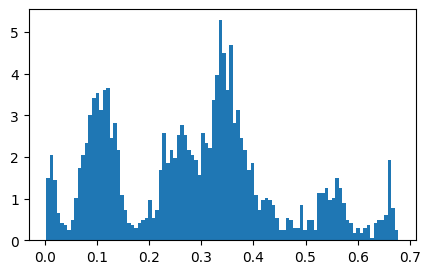

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(distances, bins=100, density=True)

In [80]:
distance_bins = np.linspace(0, 1.0, 100)
hist_counts = []
for bbox in tqdm(bboxes):
    pts = {k: filter_bounded(v, bbox) for k, v in points_final.items()}
    hist_counts.append(
        point_to_set_correlation(
            pts["desmin"],
            pts["actinin"],
            roi=bbox,
            distance_bins=distance_bins,
        )
    )
    # tree = scspatial.KDTree(pts["actinin"])
    # distances, _ = tree.query(pts["desmin"])
    # hist_counts.append(np.histogram(distances, distance_bins, density=True)[0])

100%|██████████| 100/100 [00:49<00:00,  2.00it/s]
/tmp/ipykernel_1547542/2368633186.py:54: RuntimeWarning: divide by zero encountered in divide
  coeff = 10000 / (np.diff(cumulative_counts) * n_points)
/tmp/ipykernel_1547542/2368633186.py:56: RuntimeWarning: invalid value encountered in multiply
  return coeff * H_ab
100%|██████████| 16/16 [12:15<00:00, 45.96s/it]


In [81]:
hist_counts_total = dict()
hist_counts_total["actinin"] = hist_counts

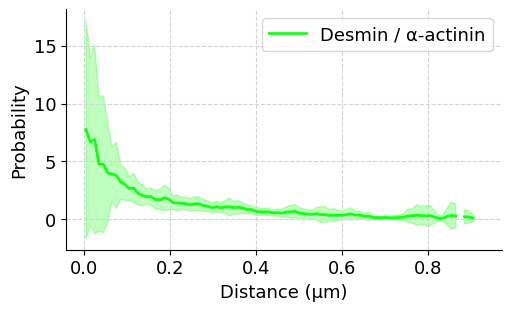

In [82]:
plt.rc("font", size=13)
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

ax = line_and_bandplot(
    ax,
    bin_centers,
    np.mean(hist_counts, axis=0),
    np.std(hist_counts, axis=0),
    color="#00FF00",
    label="Desmin / α-actinin",
    linewidth=2.0,
    alpha=0.9,
    alpha_band=0.25,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Distance (μm)")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")

# ax.set_ylim((0, 20))
# fig.savefig("../figures/fig_2/2d.svg", dpi=500)

In [ ]:
df = pl.read_csv("../data/results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

100%|██████████| 25/25 [02:10<00:00,  5.24s/it]


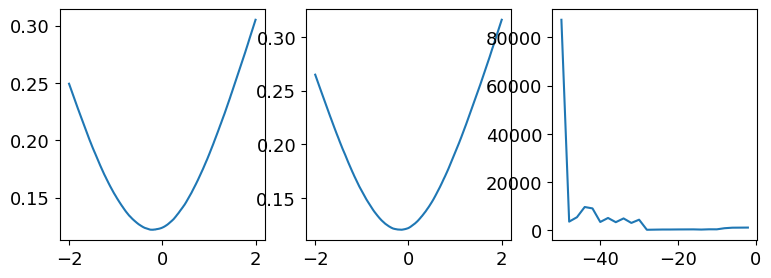

In [84]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-50, 0.0, 2.0),
        min_cluster_size=200,
        min_samples=1,
        clustering_species="actin",
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_final = {k: transform_fn(v) for k, v in points.items()}

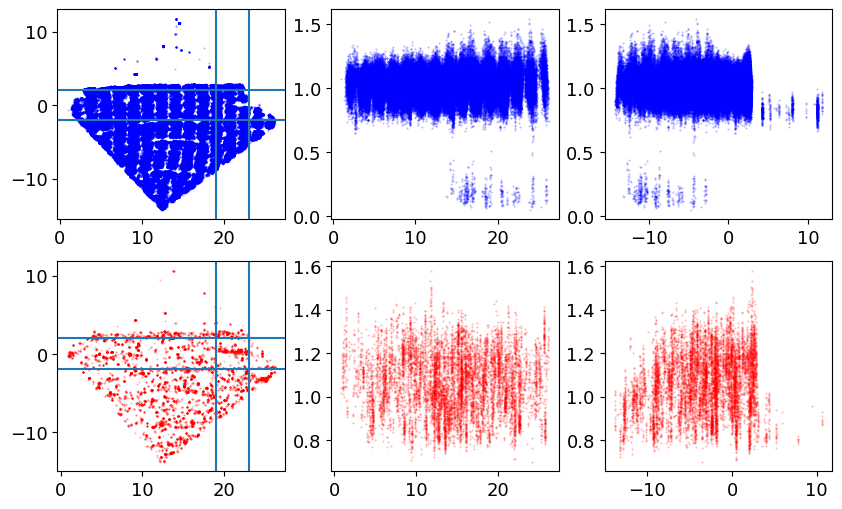

In [85]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("actin", "desmin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    x0 = 19.0
    y0 = -2
    ax.axhline(y=y0)
    ax.axhline(y=y0 + 4)
    ax.axvline(x=x0)
    ax.axvline(x=x0 + 4)


In [86]:
x0s = (3, 7, 7, 11, 11, 11, 15, 15, 15, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, 0.5, -3.5, -7.5, -2)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [89]:
distance_bins = np.linspace(0, 1.0, 100)
hist_counts = []
for bbox in tqdm(bboxes):
    pts = {k: filter_bounded(v, bbox) for k, v in points_final.items()}
    hist_counts.append(
        point_to_set_correlation(
            pts["desmin"],
            pts["actin"],
            roi=bbox,
            distance_bins=distance_bins,
        )
    )
    # tree = scspatial.KDTree(pts["actin"])
    # distances, _ = tree.query(pts["desmin"])
    # hist_counts.append(np.histogram(distances, distance_bins, density=True)[0])

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]
/tmp/ipykernel_1547542/340775410.py:54: RuntimeWarning: divide by zero encountered in divide
  coeff = 10000 / (np.diff(cumulative_counts) * n_points)
/tmp/ipykernel_1547542/340775410.py:56: RuntimeWarning: invalid value encountered in multiply
  return coeff * H_ab
100%|██████████| 10/10 [19:49<00:00, 118.95s/it]


In [90]:
hist_counts_total["actin"] = hist_counts

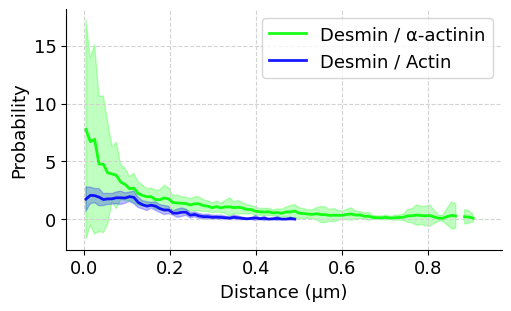

In [91]:
plt.rc("font", size=13)
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

for name, counts in hist_counts_total.items():
    ax = line_and_bandplot(
        ax,
        bin_centers,
        np.mean(counts, axis=0),
        np.std(counts, axis=0),
        color=COLOR_DICT[name],
        label=f"Desmin / {LABEL_DICT[name]}",
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Distance (μm)")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
# ax.set_ylim((0, 20))
fig.savefig("../figures/fig_2/2c.svg", dpi=500)

In [21]:
for name, counts in hist_counts_total.items():
    print(name, bin_centers[np.argmax(np.mean(counts, axis=0))])


actinin 0.196969696969697
actin 0.03535353535353536
